<a href="https://colab.research.google.com/github/Gehlen05/Aprendizado-Maquina/blob/main/deteteccao_fraude_autoencoder_desbalanceada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Rede Neural Autoencoder para Detecção de Fraude
    Neste trabalho foi desenvolvida uma rede neural Autoencoder para detecção de fraudes em transações de cartão de 
    crédito. O dataset utilizado está disponível na kaggle. O dataset é desbalanceado como mostrado em trabalhos 
    passados, onde a parte de tratamento dos dados foi explicado nos trabalhos passados. Neste será focado na 
    explicação do desenvolvimento da rede neural.
    Link trabalho passado: 
    https://github.com/Gehlen05/Aprendizado-Maquina/blob/main/Regressao_logistica_arvore_knn_deteccao_fraude_cartao_credito.ipynb 

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import metrics
from ast import increment_lineno
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay
from keras.layers import Input, Dense
from keras import regularizers
from keras.models import Model, load_model

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/creditcard.csv')
df.head()

Mounted at /content/drive


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
std_scaler = StandardScaler()
rob_scaler = RobustScaler()
df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))
df.drop(['Time','Amount'], axis=1, inplace=True)

In [ ]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960


In [ ]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']
df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

In [ ]:
df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


0    284315
1       492
Name: Class, dtype: int64


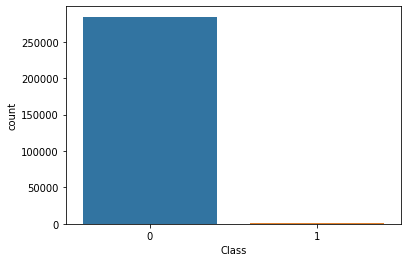

In [ ]:
target = 'Class'
ax = sns.countplot(x=target,data=df)
print(df[target].value_counts())



In [ ]:
x = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=314)

In [ ]:


x_train, x_test = train_test_split(df, test_size=0.2, random_state=314)
x_train = x_train[x_train.Class == 0]       # where normal transactions
x_train = x_train.drop(['Class'], axis=1)   # drop the class column


test_y = x_test['Class']                    # save the class column for the test set
x_test = x_test.drop(['Class'], axis=1)     # drop the class column

x_train = x_train.values                    # transform to ndarray
x_test = x_test.values       

In [ ]:
x_train.shape

(227468, 30)

In [ ]:
nb_epoch = 10
batch_size = 128
input_dim = x_train.shape[1] #num of columns, 30
encoding_dim = 18
hidden_dim1 = 30 #int(encoding_dim / 2) #i.e. 7
hidden_dim2 = 15
hidden_dim3 = 5
learning_rate = 1e-7
input_dim


30

In [ ]:


# This returns a tensor
input_layer = Input(shape=(input_dim, ))

# a layer instance is callable on a tensor, and returns a tensor
# Dense implements the operation: output = activation(dot(input, kernel) + bias), where
# activation is the element-wise activation function passed as the activation argument, 
# kernel is a weights matrix created by the layer, and 
# bias is a bias vector created by the layer (only applicable if use_bias is True).

# activity_regularizer: Regularizer function applied to the output of the layer
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim1, activation="elu")(encoder)
encoder = Dense(hidden_dim2, activation="elu")(encoder)
encoder = Dense(hidden_dim3, activation="tanh")(encoder)
encoder = Dense(hidden_dim2, activation="tanh")(encoder)
decoder = Dense(hidden_dim3, activation='elu')(encoder)
decoder = Dense(hidden_dim2, activation='tanh')(encoder)
decoder = Dense(hidden_dim1, activation='tanh')(decoder)
decoder = Dense(input_dim, activation='elu')(decoder)

# This creates a model that includes
# the Input layer and four Dense layers
autoencoder = Model(inputs=input_layer, outputs=decoder)



In [ ]:
autoencoder.compile(optimizer='Adam', loss='mean_squared_error', metrics = ['accuracy'])

In [ ]:
epochs_hist = autoencoder.fit(x_train, x_train, epochs=10)
# history = autoencoder.fit(x=x_train, y=x_train,
                          # epochs=nb_epoch,
                          # batch_size=batch_size,
                          # shuffle=True)

Epoch 1/10
7121/7121 [==============================] - 20s 3ms/step - loss: 0.5770 - accuracy: 0.6826
Epoch 2/10
7121/7121 [==============================] - 19s 3ms/step - loss: 0.5657 - accuracy: 0.6845
Epoch 3/10
7121/7121 [==============================] - 19s 3ms/step - loss: 0.5561 - accuracy: 0.6868
Epoch 4/10
7121/7121 [==============================] - 19s 3ms/step - loss: 0.5481 - accuracy: 0.6913
Epoch 5/10
7121/7121 [==============================] - 19s 3ms/step - loss: 0.5436 - accuracy: 0.6951
Epoch 6/10
7121/7121 [==============================] - 19s 3ms/step - loss: 0.5438 - accuracy: 0.6978
Epoch 7/10
7121/7121 [==============================] - 20s 3ms/step - loss: 0.5380 - accuracy: 0.7012
Epoch 8/10
7121/7121 [==============================] - 19s 3ms/step - loss: 0.5298 - accuracy: 0.7067
Epoch 9/10
7121/7121 [==============================] - 19s 3ms/step - loss: 0.5257 - accuracy: 0.7092
Epoch 10/10
7121/7121 [==============================] - 21s 3ms/step - l

In [ ]:
y_pred_test = autoencoder.predict(x_test)

1781/1781 [==============================] - 3s 2ms/step


In [ ]:
y_pred_test.shape


(56962, 30)

In [ ]:
# y_pred_test[y_pred_test > 0.5] = 1
# y_pred_test[y_pred_test < 0.5] = 0

In [ ]:


test_x_predictions = autoencoder.predict(x_test)
mse = np.mean(np.power(x_test - test_x_predictions, 2), axis=1) # original
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test})
error_df.describe()



1781/1781 [==============================] - 3s 1ms/step


,Reconstruction_error,True_class
count,56962.000000,56962.000000
mean,0.489140,0.002019
std,3.175245,0.044887
min,0.009993,0.000000
25%,0.110735,0.000000
50%,0.193802,0.000000
75%,0.350624,0.000000
max,299.676029,1.000000


In [ ]:
test_x_predictions[0]

array([ 0.33372855, -0.293494  ,  1.1312962 , -0.0251168 , -0.30095726,
        0.18558663, -0.33257568, -0.5535257 ,  0.00648811,  0.12272948,
       -0.3877645 , -0.07900757,  1.4327974 ,  0.84718025, -0.32243937,
        0.4873247 ,  0.26605618,  0.21358502, -0.23603445,  0.14101775,
        0.03594941, -0.1003828 , -0.2135852 , -0.35646558,  0.02913517,
       -0.13479161,  0.24321416,  0.19086929, -0.01411164,  0.04518455],
      dtype=float32)

In [ ]:
error_df.head(10)

,Reconstruction_error,True_class
0,0.081915,0
1,0.476811,0
2,0.091330,0
3,0.064432,0
4,0.072501,0
5,0.212165,0
6,0.424495,0
7,0.641137,0
8,0.279538,0
9,0.098291,0


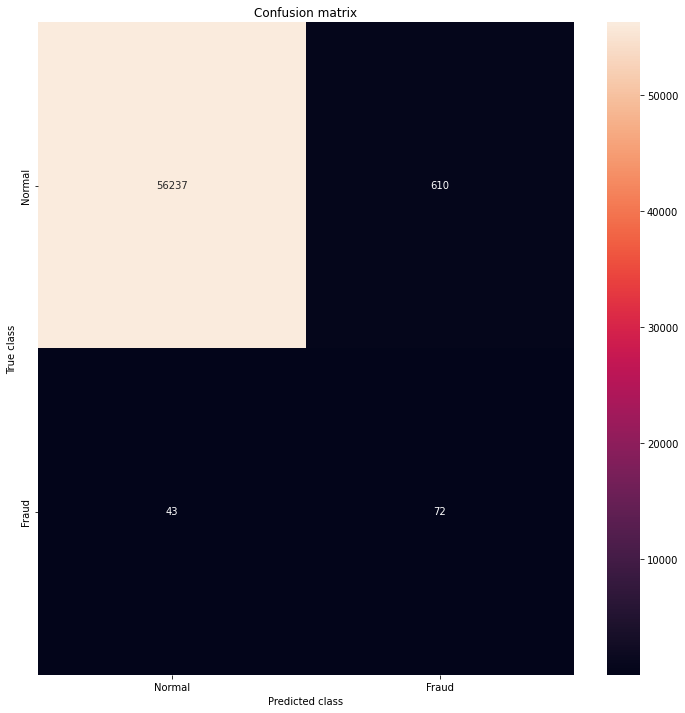

In [ ]:
LABELS = ["Normal","Fraud"]
pred_y = [1 if e > 4 else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
print('Acurácia: ', metrics.accuracy_score(y_test, pred_y))

Acurácia:  0.9885362171272076


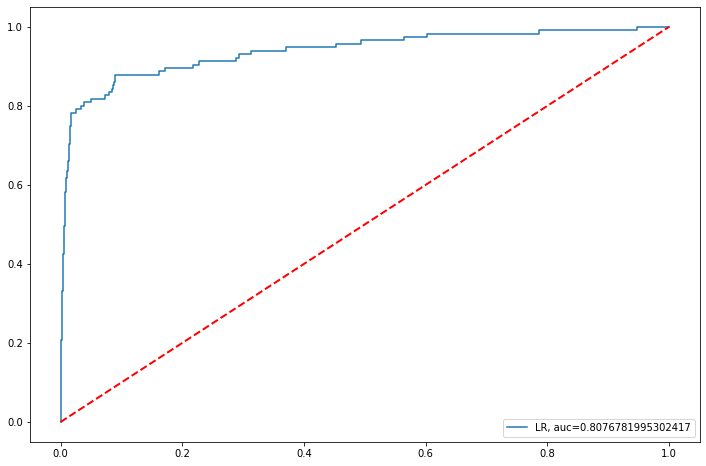

In [ ]:

# fpr, tpr, _ = metrics.roc_curve(y_test, pred_y)
fpr, tpr, _ = metrics.roc_curve(error_df.True_class, error_df.Reconstruction_error)
auc = metrics.roc_auc_score(y_test, pred_y)

plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr, tpr, label ="LR, auc="+str(auc))
plt.plot([0,1], [0,1], color='red', lw=2, linestyle ='--')
plt.legend(loc=4)



In [ ]:
epochs_hist.history.keys()

dict_keys(['loss', 'accuracy'])

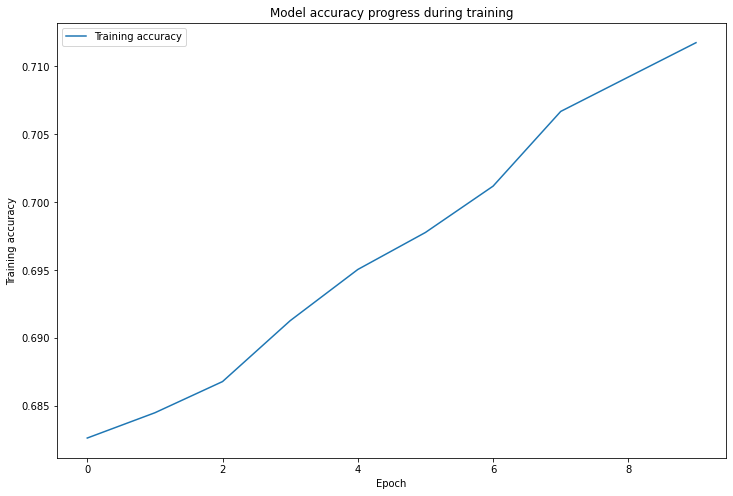

In [ ]:
plt.plot(epochs_hist.history['accuracy'])
plt.title('Model accuracy progress during training')
plt.xlabel('Epoch')
plt.ylabel('Training accuracy')
plt.legend(['Training accuracy'])

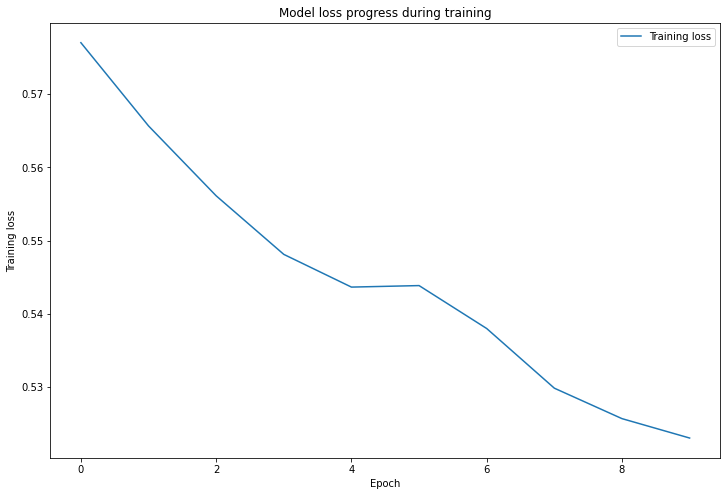

In [ ]:
plt.plot(epochs_hist.history['loss'])
plt.title('Model loss progress during training')
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.legend(['Training loss'])